## Principal Compontent Analysis: feats & rxn_solUD
Some considerations or assumptions:
-   Correlation between features
-   Std is requerid OK 
-   Outliers?
-   No missing values. OK

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
%cd ..

/home/belu/VS Workplace/2021-re-pendleton-perovskite


In [3]:
import src.data.notebook_utils as utils
results = '/notebook/results/correlation/'
df = utils.read_data()
columns_by_type = utils.get_columns(df.columns)
used_data = utils.get_used_columns(df.columns)


In [4]:
for key, cols in columns_by_type.items():
    print('#Cols for type {}: {}'.format(key, len(cols)))

#Cols for type _rxn_: 9
#Cols for type _feat_: 67
#Cols for type solUD: 8
#Cols for type chem: 36


In [5]:
def apply_pca(df, cols, n_components):
    scaler = StandardScaler()
    std_df =pd.DataFrame(scaler.fit_transform(df[cols]), columns=cols)
    pca_number = min(len(cols), n_components)
    pca_columns = ['PCA_'+ str(n) for n in range(pca_number)]
    pca = PCA(n_components=pca_number, svd_solver = 'auto')
    Principal_components=pca.fit_transform(std_df)
    pca_df = pd.DataFrame(data = Principal_components, columns = pca_columns)
    return pca, pca_df 

In [6]:
def plot_scree_pca(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');


In [7]:
df_feat = df[columns_by_type['_feat_']]

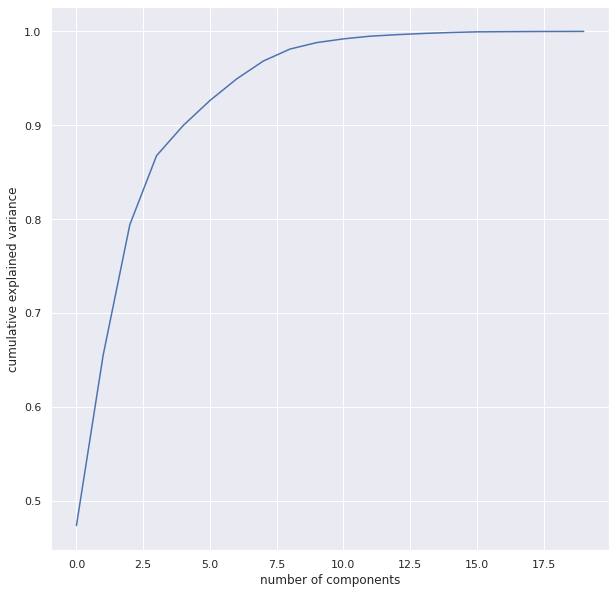

In [8]:
pca_ft, pca_df_ft = apply_pca(df, list(columns_by_type['_feat_']), 20)
plot_scree_pca(pca_ft)

Drop all constants columns does not affect pca results

In [9]:
df_feat_noctes = df_feat.loc[:, (df_feat != df_feat.iloc[0]).any()] 
df_feat_cols = df_feat_noctes.columns
pca_ft_nocte, pca_df_ft_nocte = apply_pca(df, df_feat_cols, 20)
#plot_scree_pca(pca)

In [10]:
pca_ft_nocte.components_[12:,:].shape

(8, 59)

In [11]:
np.savetxt("heapmap_data.csv", pca_ft_nocte.components_[:8,], delimiter=",")

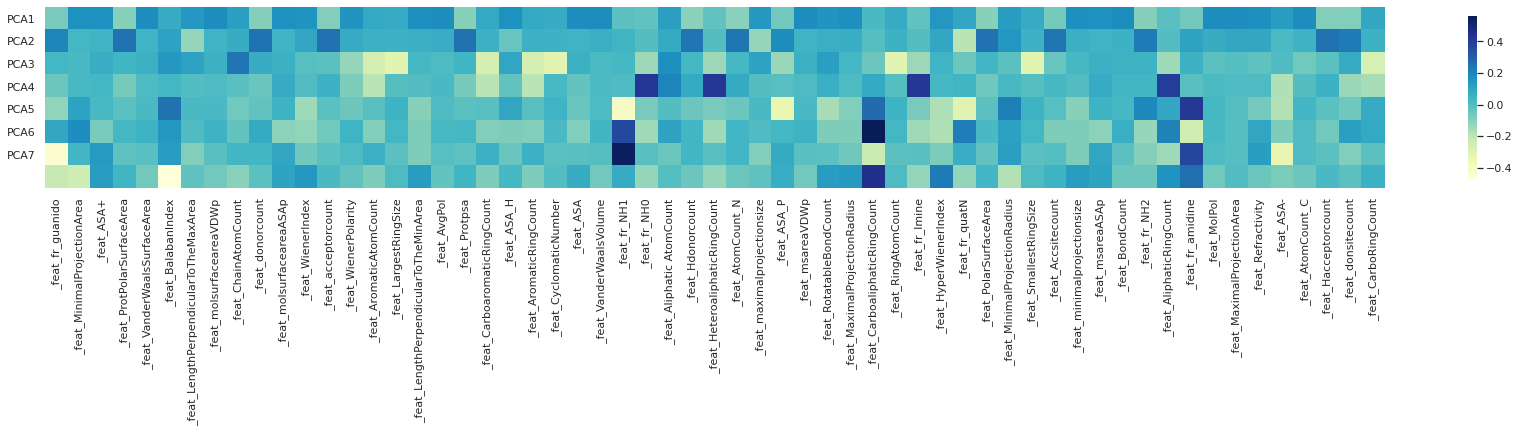

In [136]:
plt.figure(figsize=(30,15))
#ordenar por aporte de componente
# transponer 
ax = sns.heatmap(pca_ft_nocte.components_[:8,],
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,8)],
                 xticklabels=df_feat_cols, cbar=True, square=True, cbar_kws={"shrink": .2})

In [12]:
import plotly.graph_objects as go
import plotly.figure_factory as ff

from scipy.spatial.distance import pdist, squareform

import scipy.cluster.hierarchy as sch

In [21]:
data_array = df[df_feat_cols].values
data_array = data_array.transpose()


In [22]:
data_array.shape

(59, 6241)

In [23]:
labels = df_feat_cols

In [24]:
fig = ff.create_dendrogram(data_array, orientation='bottom', labels=labels)
for i in range(len(fig['data'])):
    fig['data'][i]['yaxis'] = 'y2'

# Create Side Dendrogram
dendro_side = ff.create_dendrogram(data_array, orientation='right')
for i in range(len(dendro_side['data'])):
    dendro_side['data'][i]['xaxis'] = 'x2'

# Add Side Dendrogram Data to Figure
for data in dendro_side['data']:
    fig.add_trace(data)


# Create Heatmap
dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
dendro_leaves = list(map(int, dendro_leaves))
data_dist = pdist(data_array)
heat_data = squareform(data_dist)
heat_data = heat_data[dendro_leaves,:]
heat_data = heat_data[:,dendro_leaves]

heatmap = [
    go.Heatmap(
        x = dendro_leaves,
        y = dendro_leaves,
        z = heat_data,
        colorscale = 'Blues'
    )
]

heatmap[0]['x'] = fig['layout']['xaxis']['tickvals']
heatmap[0]['y'] = dendro_side['layout']['yaxis']['tickvals']

# Add Heatmap Data to Figure
for data in heatmap:
    fig.add_trace(data)

# Edit Layout
fig.update_layout({'width':800, 'height':800,
                         'showlegend':False, 'hovermode': 'closest',
                         })
# Edit xaxis
fig.update_layout(xaxis={'domain': [.15, 1],
                                  'mirror': False,
                                  'showgrid': False,
                                  'showline': False,
                                  'zeroline': False,
                                  'ticks':""})
# Edit xaxis2
fig.update_layout(xaxis2={'domain': [0, .15],
                                   'mirror': False,
                                   'showgrid': False,
                                   'showline': False,
                                   'zeroline': False,
                                   'showticklabels': False,
                                   'ticks':""})

# Edit yaxis
fig.update_layout(yaxis={'domain': [0, .85],
                                  'mirror': False,
                                  'showgrid': False,
                                  'showline': False,
                                  'zeroline': False,
                                  'showticklabels': False,
                                  'ticks': ""
                        })
# Edit yaxis2
fig.update_layout(yaxis2={'domain':[.825, .975],
                                   'mirror': False,
                                   'showgrid': False,
                                   'showline': False,
                                   'zeroline': False,
                                   'showticklabels': False,
                                   'ticks':""})

In [ ]:
plt.figure(figsize=(30,15))

ax = sns.heatmap(pca_ft_nocte.components_[:],
                 cmap='viridis',
                 yticklabels=[ "PCA"+str(x) for x in range(1,8)],
                 xticklabels=df_feat_cols, cbar=True, square=True, cbar_kws={"shrink": .2})

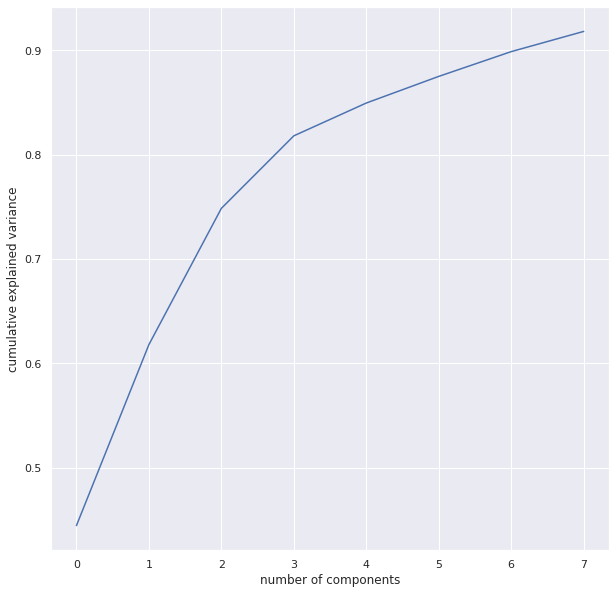

In [134]:
feat_solUD = list(columns_by_type['_feat_']) + list(columns_by_type['solUD'])
pca, pca_df = apply_pca(df, feat_solUD, 8)
plot_scree_pca(pca)

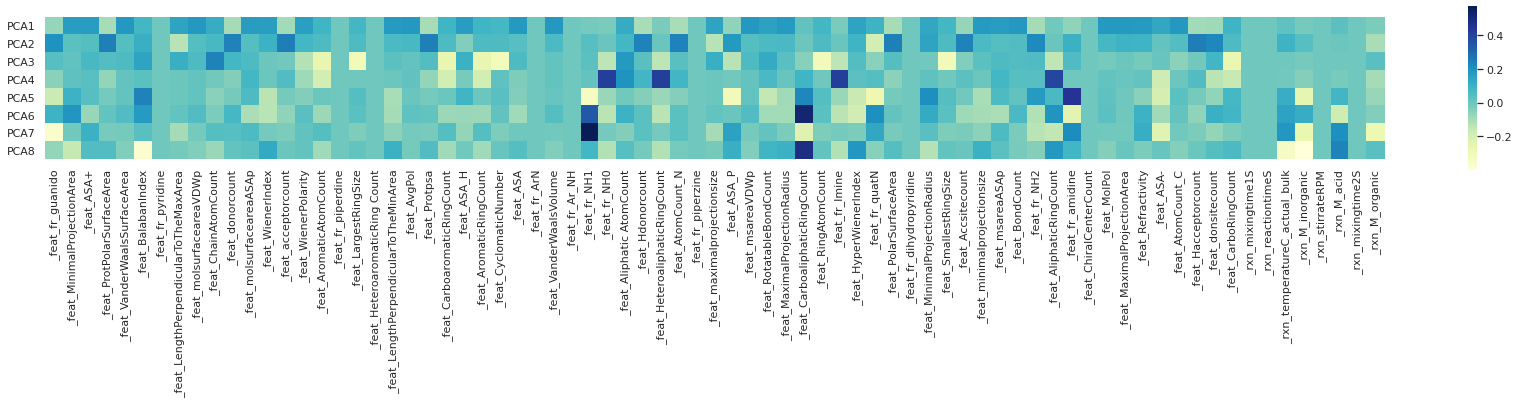

In [135]:

plt.figure(figsize=(30,15))

ax = sns.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=feat_solUD, cbar=True, square=True, cbar_kws={"shrink": .2})
#ax.set_aspect("equal")
#ax = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)

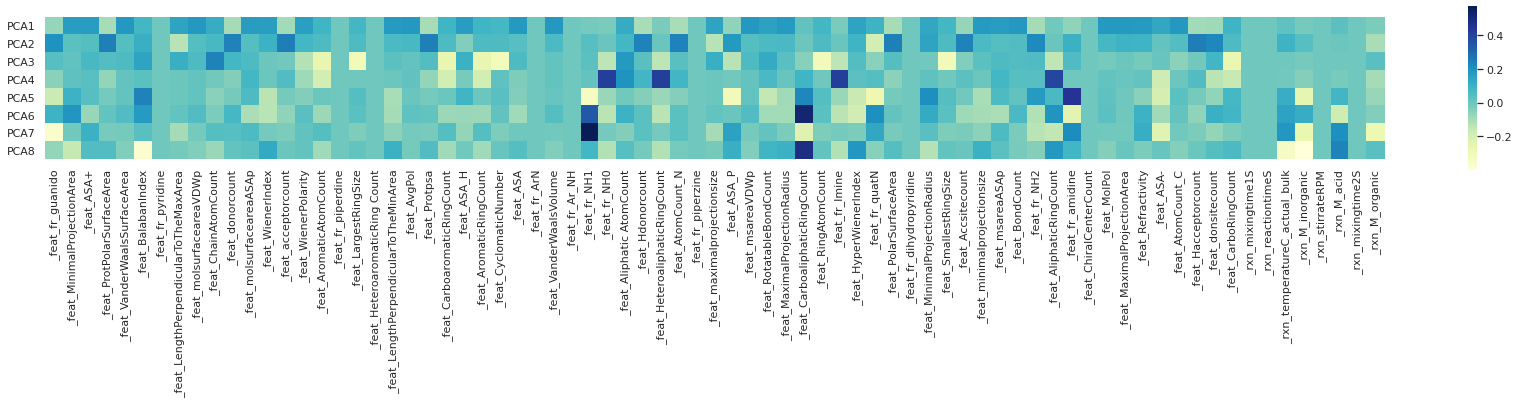

In [110]:

plt.figure(figsize=(30,15))

ax = sns.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=feat_solUD, cbar=True, square=True, cbar_kws={"shrink": .2})
#ax.set_aspect("equal")
#ax = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10)

In [529]:
std_df = final_df[independent_cols] 

In [530]:
pca_number = min(len(std_df.columns), 20)
pca_columns = ['PCA_'+ str(n) for n in range(pca_number)]
pca = PCA(n_components=pca_number, svd_solver = 'auto')
Principal_components=pca.fit_transform(std_df)
pca_df = pd.DataFrame(data = Principal_components, columns = pca_columns)

In [534]:
loadings = pd.DataFrame(pca.components_.T, columns=pca_columns, index=independent_cols)
loadings.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,PCA_19
_raw_reagent_1_v1-conc_RQQRAHKHDFPBMC-UHFFFAOYSA-L,0.000154,0.020608,-0.023857,0.012376,-0.022510,0.028547,0.283030,-0.059207,0.188726,-0.842936,-0.409406,-0.000159,0.010133,-0.006615,-0.000283,0.000072,1.257540e-14,-0.000000e+00,0.000000e+00,-0.000000e+00
_raw_reagent_2_v1-conc_QNNYEDWTOZODAS-UHFFFAOYSA-N,-0.000092,-0.002307,-0.005915,-0.015597,-0.123496,0.376598,-0.104364,-0.036105,0.089618,0.006146,-0.005565,0.165611,-0.003985,-0.003676,0.000027,-0.000393,-8.897739e-01,3.555747e-03,-2.465354e-02,1.116536e-02
_raw_M_RQQRAHKHDFPBMC-UHFFFAOYSA-L_final,0.002142,0.003693,0.011267,-0.013346,-0.091704,0.046847,0.473127,-0.267851,0.116971,0.190567,0.028077,0.002355,-0.026007,0.376843,0.000113,-0.000374,-4.355028e-02,-3.024462e-02,3.088150e-01,-1.045512e-01
_raw_M_QNNYEDWTOZODAS-UHFFFAOYSA-N_final,-0.000056,-0.001672,-0.000857,-0.011174,-0.092813,0.270928,-0.074248,-0.025407,0.066636,0.004137,-0.001223,-0.775852,0.017177,0.001343,-0.000882,-0.552264,-7.052735e-17,-9.556147e-16,1.492879e-16,1.170703e-15
_raw_reagent_2_conc_KFQARYBEAKAXIC-UHFFFAOYSA-N,-0.000071,-0.000330,-0.014536,-0.005067,0.001861,0.016375,0.105426,0.302635,0.172313,0.046449,0.011549,-0.002214,-0.128098,-0.005241,-0.004053,-0.000016,1.288929e-02,1.351348e-01,2.302859e-02,1.649111e-01


In [543]:
pca_columns_k = ['PCA_'+ str(n) for n in range(5)]


In [546]:
loadings[pca_columns_k].idxmax(axis = 0)

PCA_0                              _raw_reagent_1_volume
PCA_1           _raw_reagent_1_chemicals_1_actual_amount
PCA_2                                  _raw_v0-M_organic
PCA_3    _raw_reagent_2_conc_GIAPQOZCVIEHNY-UHFFFAOYSA-N
PCA_4           _raw_M_FCTHQYIDLRRROX-UHFFFAOYSA-N_final
dtype: object

<AxesSubplot:>

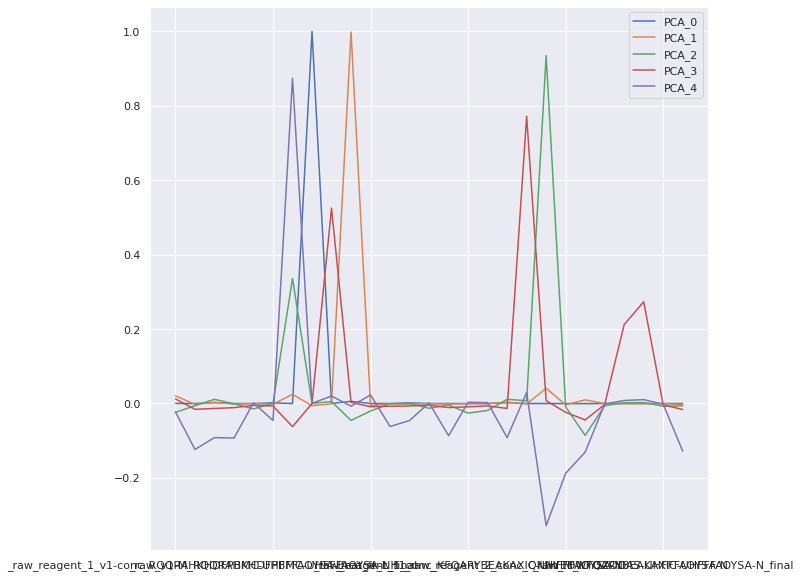

In [544]:
loadings[pca_columns_k].plot()

Text(0, 0.5, 'cumulative explained variance')

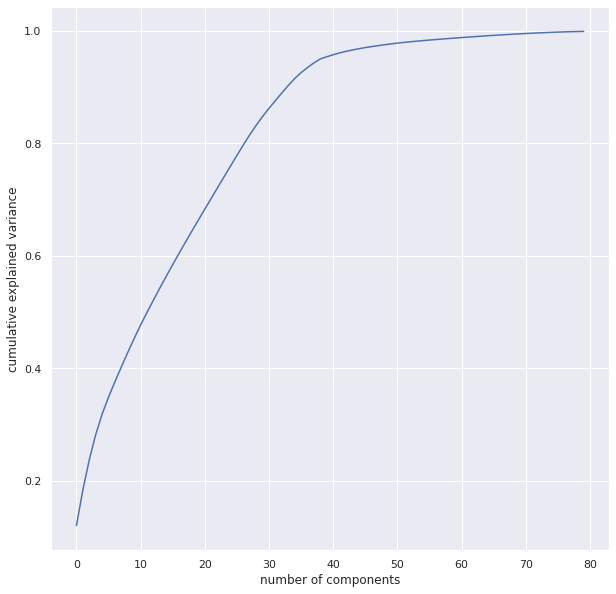

In [15]:
final_df = df
independent_cols = selected_columns
scaler = StandardScaler()
std_df =pd.DataFrame(scaler.fit_transform(final_df[list(independent_cols)]), columns=list(independent_cols))
#std_df.head()
pca, pca_df = apply_pca(std_df,80)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

<AxesSubplot:>

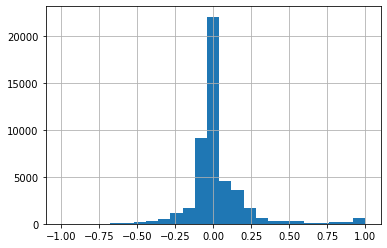

In [356]:
correlations_plot['correlation'].hist(bins=25)

In [ ]:
indepent_columns_count = [15,40,80,120]

In [286]:
correlations_plot

256    26.504454
257    26.504454
258    26.504454
259    26.504454
260    26.504454
Name: _raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N, dtype: float64

<AxesSubplot:>

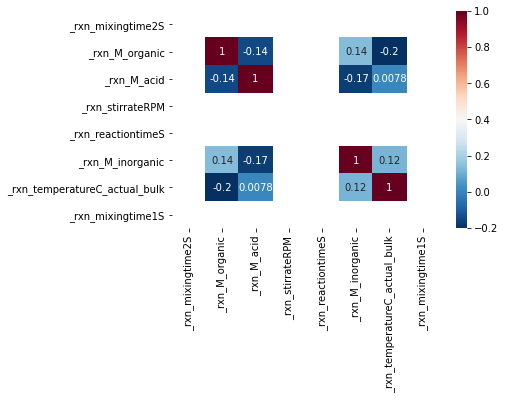

In [121]:
data_2 = df[list(columns_by_prefix[0])].corr('spearman')
sns.heatmap(data_2, 
            xticklabels=data_2.columns,
            yticklabels=data_2.columns,
            cmap='RdBu_r',
            annot=True)

In [257]:
combinations

array([['_raw_reagent_1_conc_FCTHQYIDLRRROX-UHFFFAOYSA-N',
        '_rxn_M_organic'],
       ['_raw_reagent_1_conc_FCTHQYIDLRRROX-UHFFFAOYSA-N',
        '_raw_v1-M_WGYRINYTHSORGH-UHFFFAOYSA-N_final'],
       ['_raw_reagent_1_conc_FCTHQYIDLRRROX-UHFFFAOYSA-N',
        '_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOYSA-N'],
       ...,
       ['_raw_reagent_2_chemicals_0_actual_amount',
        '_raw_reagent_2_v1-conc_JMXLWMIFDJCGBV-UHFFFAOYSA-N'],
       ['_raw_reagent_2_chemicals_0_actual_amount',
        '_raw_reagent_4_v1-conc_ZMXDDKWLCZADIW-UHFFFAOYSA-N'],
       ['_raw_reagent_2_v1-conc_JMXLWMIFDJCGBV-UHFFFAOYSA-N',
        '_raw_reagent_4_v1-conc_ZMXDDKWLCZADIW-UHFFFAOYSA-N']],
      dtype='<U50')

In [278]:
spearman_correlation

array([-1.        , -1.        , -0.98288077, ...,         nan,
               nan,         nan])

In [280]:
spearman_correlation

array([-1.        , -1.        , -0.98288077, ...,         nan,
               nan,         nan])

,0,1,correlation
46664,_raw_reagent_2_conc_NLJDBTZLVTWXRG-UHFFFAOYSA-N,_raw_reagent_1_v1-conc_NLJDBTZLVTWXRG-UHFFFAOY...,1.0
46560,_raw_reagent_1_v1-conc_ZEVRFFCPALTVDN-UHFFFAOY...,_raw_reagent_2_conc_ZEVRFFCPALTVDN-UHFFFAOYSA-N,1.0
46532,_raw_reagent_2_conc_NOHLSFNWSBZSBW-UHFFFAOYSA-N,_raw_reagent_1_conc_NOHLSFNWSBZSBW-UHFFFAOYSA-N,1.0
46531,_raw_reagent_2_conc_VNAAUNTYIONOHR-UHFFFAOYSA-N,_raw_reagent_2_v1-conc_VNAAUNTYIONOHR-UHFFFAOY...,1.0
46530,_raw_reagent_2_v1-conc_NXRUEVJQMBGVAT-UHFFFAOY...,_raw_reagent_1_conc_NXRUEVJQMBGVAT-UHFFFAOYSA-N,1.0
...,...,...,...
105106,_feat_ASA_H,_raw_reagent_2_chemicals_3_actual_amount,NaN
105107,_feat_ASA_H,_raw_reagent_1_conc_LCTUISCIGMWMAT-UHFFFAOYSA-N,NaN
105108,_feat_ASA_H,_raw_reagent_1_conc_QZCGFUVVXNFSLE-UHFFFAOYSA-N,NaN
105109,_raw_v1-M_BAMDIFIROXTEEM-UHFFFAOYSA-N_final,_raw_v1-M_NXRUEVJQMBGVAT-UHFFFAOYSA-N_final,NaN


In [266]:
correlations.head()

,0,1,correlation
0,_raw_reagent_4_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,_raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,-1.000000
1,_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,-1.000000
2,_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_6_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,-0.982881
3,_raw_reagent_6_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_4_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,-0.982881
4,_feat_fr_NH2,_feat_fr_quatN,-0.858166


In [273]:
correlations

,column1,column2,correlation
0,_raw_reagent_4_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,_raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,1.000000
1,_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,1.000000
2,_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_6_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,0.982881
3,_raw_reagent_6_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_4_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,0.982881
4,_feat_fr_NH2,_feat_fr_quatN,0.858166
...,...,...,...
46660,_raw_reagent_2_conc_JBOIAZWJIACNJF-UHFFFAOYSA-N,_raw_reagent_2_v1-conc_JBOIAZWJIACNJF-UHFFFAOY...,1.000000
46661,_raw_reagent_1_v1-conc_KFQARYBEAKAXIC-UHFFFAOY...,_raw_reagent_1_conc_KFQARYBEAKAXIC-UHFFFAOYSA-N,1.000000
46662,_feat_VanderWaalsSurfaceArea,_feat_molsurfaceareaVDWp,1.000000
46663,_raw_reagent_2_v1-conc_NXRUEVJQMBGVAT-UHFFFAOY...,_raw_reagent_1_conc_NXRUEVJQMBGVAT-UHFFFAOYSA-N,1.000000


In [268]:
correlations['correlation'] = correlations['correlation'].apply(lambda x: abs(x))

In [269]:
correlations.to_csv('abs_pair_correlations_spearman.csv', index=None)

In [270]:
correlations.sort_values(['correlation'],ascending=False)

,column1,column2,correlation
0,_raw_reagent_4_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,_raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,1.000000
1,_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_6_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,1.000000
2,_raw_reagent_4_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_6_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,0.982881
3,_raw_reagent_6_v1-conc_BDAGIHXWWSANSR-UHFFFAOY...,_raw_reagent_4_conc_BDAGIHXWWSANSR-UHFFFAOYSA-N,0.982881
4,_feat_fr_NH2,_feat_fr_quatN,0.858166
...,...,...,...
46660,_raw_reagent_2_conc_JBOIAZWJIACNJF-UHFFFAOYSA-N,_raw_reagent_2_v1-conc_JBOIAZWJIACNJF-UHFFFAOY...,1.000000
46661,_raw_reagent_1_v1-conc_KFQARYBEAKAXIC-UHFFFAOY...,_raw_reagent_1_conc_KFQARYBEAKAXIC-UHFFFAOYSA-N,1.000000
46662,_feat_VanderWaalsSurfaceArea,_feat_molsurfaceareaVDWp,1.000000
46663,_raw_reagent_2_v1-conc_NXRUEVJQMBGVAT-UHFFFAOY...,_raw_reagent_1_conc_NXRUEVJQMBGVAT-UHFFFAOYSA-N,1.000000


In [225]:
df['_raw_M_FJFIJIDZQADKEE-UHFFFAOYSA-N_final'].value_counts()

0.000000    6146
1.113352       4
0.828153       4
0.194150       4
0.923219       3
            ... 
0.172586       1
0.795418       1
0.944815       1
1.001404       1
0.818313       1
Name: _raw_M_FJFIJIDZQADKEE-UHFFFAOYSA-N_final, Length: 81, dtype: int64

In [276]:
from pathlib import Path

full_plot_path = folder_replicated_results + 'plots/'
Path(full_plot_path).mkdir(parents=True, exist_ok=True)